
# Exercise 2.1 — Strategy 1+2 (Nakamoto Consensus)
**Goal:** simulate *strategy 1+2*, estimate its long-run revenue rate, and compare the simulation with the **theoretical formula** from the course.

---

## What we measure

For each attack **cycle**, we record:
- \(G\): number of Alice blocks that become **official** (rewarded)
- \(H\): increase of the **official chain height** during the cycle

The long-run performance metric is:
$$
\
\gamma = \frac{\mathbb{E}[G]}{\mathbb{E}[H]}.
\
$$

**Honest mining benchmark:** if Alice mines honestly, her long-run share of official blocks is simply:
$$
\
\gamma_{\text{honest}} = q,
$$
where **q** is Alice's **relative hashing power**.

---
## The key threshold

The course[1] on  gives the following theoretical revenue rate for strategy 1+2:

$$
\gamma(q) = \frac{q^2(4-q)}{1+q+q^3}
$$

Strategy 1+2 is **profitable** when:

$$
\gamma(q) > q
\quad \Longleftrightarrow \quad
q > \sqrt{2} - 1 \approx 0.4142
$$

This is a **hashing power threshold** (not a time threshold):

- $q$ is the fraction of total network hash rate controlled by Alice.
- For example, $q = 0.42$ means Alice controls 42% of the total hash power.

[1]: page 11/27 on Nakamoto Consensus Slide

In [ ]:
import random
from collections import Counter
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


## Model: Why the next block is Alice with probability **q**

In Proof-of-Work, each side’s time-to-find-a-block is typically modeled as exponential:
- $(T_A \sim \text{Exp}(\lambda_A))$ for Alice

- $(T_B \sim \text{Exp}(\lambda_B))$ for Bob

Then:
$$
\mathbb{P}(T_A < T_B) = \frac{\lambda_A}{\lambda_A+\lambda_B} = q.
$$

So each discovered block can be simulated as a Bernoulli trial:
- "A" with probability $q$
- "B" with probability $p=1-q$

This is the model used in the course slides.



## Theoretical formula

We will compare simulation to:
$$
\gamma(q) = \frac{q^2(4-q)}{1+q+q^3}.
$$


In [ ]:
def gamma_theoretical(q: float) -> float:
    """Theoretical gamma = E[G]/E[H] from the course."""
    return (q * q * (4.0 - q)) / (1.0 + q + (q ** 3))

q_star = math.sqrt(2) - 1  # profitability threshold
q_star


0.41421356237309515


## Strategy 1+2 (cycle definition)

A **cycle** starts when everyone is mining on the same official tip.

- If **Bob** finds the first block: Alice **abandons immediately** and returns to honest mining.  
  Outcome: **B**.

- If **Alice** finds the first block: she **withholds** it and waits for **two more block discoveries**, then the cycle ends.
  Possible outcomes: **AAA, AAB, ABA, ABB**.

Outcome space:
$$
\Omega = \{B,\; AAA,\; AAB,\; ABA,\; ABB\}.
$$

Payoffs \((G,H)\) from the slides:
- \(B\): \((0,1)\)
- \(AAA\): \((3,3)\)
- \(AAB\), \(ABA\): \((2,2)\)
- \(ABB\): \((0,2)\)


In [ ]:
@dataclass
class SimResult:
    q: float
    N: int
    EG: float
    EH: float
    gamma_hat: float
    counts: Counter
    gamma_theory: float
    honest_rate: float


def draw_A_or_B(q: float) -> str:
    """Return 'A' with probability q else 'B'."""
    return "A" if random.random() < q else "B"


def simulate_one_cycle(q: float):
    """Simulate one cycle of strategy 1+2. Returns (G, H, outcome)."""
    if not (0.0 <= q <= 1.0):
        raise ValueError("q must be in [0,1].")

    # 1) First discovery
    x1 = draw_A_or_B(q)
    if x1 == "B":
        # Bob finds first -> Alice abandons immediately
        return 0, 1, "B"

    # 2) Alice found first, withholds, then wait for two more discoveries
    x2 = draw_A_or_B(q)
    x3 = draw_A_or_B(q)
    outcome = "A" + x2 + x3  # AAA, AAB, ABA, ABB

    # 3) Payoffs from the slides
    if outcome == "AAA":
        return 3, 3, "AAA"
    if outcome in ("AAB", "ABA"):
        return 2, 2, outcome
    if outcome == "ABB":
        return 0, 2, "ABB"

    raise RuntimeError(f"Unexpected outcome: {outcome}")


def run_simulation(q: float, N: int = 200_000, seed: int = 0) -> SimResult:
    """Run Monte Carlo simulation over N cycles."""
    random.seed(seed)

    sumG = 0
    sumH = 0
    counts = Counter()

    for _ in range(N):
        G, H, outcome = simulate_one_cycle(q)
        sumG += G
        sumH += H
        counts[outcome] += 1

    EG = sumG / N
    EH = sumH / N
    gamma_hat = EG / EH

    return SimResult(
        q=q,
        N=N,
        EG=EG,
        EH=EH,
        gamma_hat=gamma_hat,
        counts=counts,
        gamma_theory=gamma_theoretical(q),
        honest_rate=q
    )



## Step 1 — Run a single simulation (readable output)

We start with one value of $q$ (e.g. 0.45) and display:
- $\widehat{\gamma}(simulation)$
- $\gamma(q) (theory)$
- $q(honest)$
- $Advantage: \widehat{\gamma} - q$

If Advantage > 0, the strategy is profitable for that $q$.


In [ ]:
res = run_simulation(q=0.45, N=300_000, seed=123)

summary = {
    "q": res.q,
    "N": res.N,
    "EG": res.EG,
    "EH": res.EH,
    "gamma_sim": res.gamma_hat,
    "gamma_theory": res.gamma_theory,
    "honest=q": res.honest_rate,
    "advantage (sim - honest)": res.gamma_hat - res.honest_rate,
}
pd.DataFrame([summary])


,q,N,EG,EH,gamma_sim,gamma_theory,honest=q,advantage (sim - honest)
0,0.2,300000,0.152957,1.209167,0.126498,0.125828,0.2,-0.073502



## Step 2 — Sanity check: outcome probabilities

Theoretical outcome probabilities (from the slides) are:
- $P(B)=p$
- $P(AAA)=q^3$
- $P(AAB)=P(ABA)=pq^2$
- $P(ABB)=p^2q$

We compare them to empirical frequencies from simulation.


In [ ]:
def outcome_probabilities_theory(q: float):
    p = 1 - q
    return {
        "B": p,
        "AAA": q**3,
        "AAB": p*(q**2),
        "ABA": p*(q**2),
        "ABB": (p**2)*q
    }

def outcome_frequencies_empirical(counts: Counter, N: int):
    return {k: counts.get(k, 0)/N for k in ["B","AAA","AAB","ABA","ABB"]}

theory_probs = outcome_probabilities_theory(res.q)
emp_probs = outcome_frequencies_empirical(res.counts, res.N)

df_probs = pd.DataFrame({
    "theory": theory_probs,
    "simulation": emp_probs,
})
df_probs["abs_error"] = (df_probs["simulation"] - df_probs["theory"]).abs()
df_probs


,theory,simulation,abs_error
B,0.800,0.798910,0.001090
AAA,0.008,0.008077,0.000077
AAB,0.032,0.032300,0.000300
ABA,0.032,0.032063,0.000063
ABB,0.128,0.128650,0.000650



## Step 3 — Sweep over many $q$ values

We compute $\widehat{\gamma}$ for many values of $q$ and compare:
- simulation $\widehat{\gamma}$
- theory $\gamma(q)$
- honest line $q$
- advantage $\widehat{\gamma}-q$

We expect the advantage to change sign near $q^* \approx 0.4142$.


In [ ]:
def run_grid(q_values, N=200_000, seed=2024):
    rows = []
    for i, q in enumerate(q_values):
        r = run_simulation(q=float(q), N=N, seed=seed+i)
        rows.append({
            "q": r.q,
            "gamma_sim": r.gamma_hat,
            "gamma_theory": r.gamma_theory,
            "honest=q": r.honest_rate,
            "advantage_sim": r.gamma_hat - r.honest_rate,
        })
    return pd.DataFrame(rows)

q_values = np.linspace(0.05, 0.49, 25)
df = run_grid(q_values, N=200_000, seed=123)
df.head()


,q,gamma_sim,gamma_theory,honest=q,advantage_sim
0,0.050000,0.009856,0.009404,0.050000,-0.040144
1,0.068333,0.017023,0.017179,0.068333,-0.051310
2,0.086667,0.027112,0.027033,0.086667,-0.059555
3,0.105000,0.038702,0.038821,0.105000,-0.066298
4,0.123333,0.053261,0.052407,0.123333,-0.070072


In [ ]:
# Show a compact table around the threshold
df_sorted = df.sort_values("q").reset_index(drop=True)
df_sorted.loc[(df_sorted["q"] >= 0.35) & (df_sorted["q"] <= 0.48)]


,q,gamma_sim,gamma_theory,honest=q,advantage_sim
17,0.361667,0.336779,0.337767,0.361667,-0.024887
18,0.380000,0.366103,0.364303,0.380000,-0.013897
19,0.398333,0.390507,0.391009,0.398333,-0.007826
20,0.416667,0.417219,0.417800,0.416667,0.000552
21,0.435000,0.443887,0.444593,0.435000,0.008887
22,0.453333,0.473099,0.471310,0.453333,0.019766
23,0.471667,0.498252,0.497873,0.471667,0.026585



## Plot 1 — Revenue rate $\gamma$ vs hashing power $q$

We plot:
- Honest benchmark: $\gamma=q$ (straight line)
- Strategy 1+2 theory: $\gamma(q)$
- Simulation points: $\widehat{\gamma}$
- Vertical line at $q^*=\sqrt{2}-1$


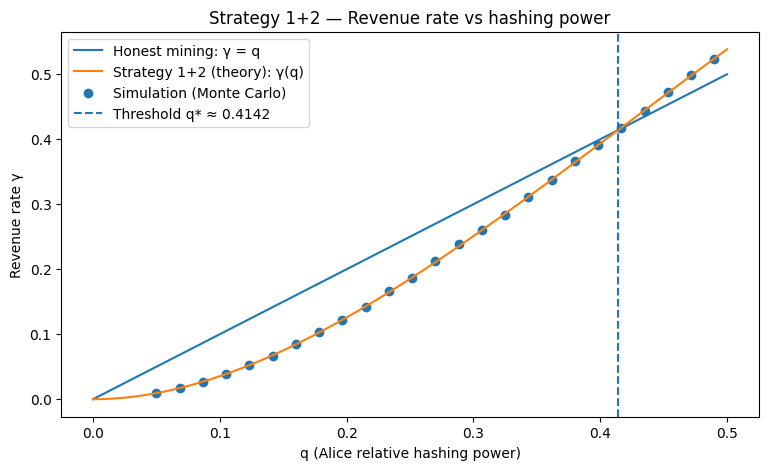

In [ ]:
q_plot = np.linspace(0.0, 0.5, 400)
gamma_plot = np.array([gamma_theoretical(q) for q in q_plot])

plt.figure(figsize=(9, 5))
plt.plot(q_plot, q_plot, label="Honest mining: γ = q")
plt.plot(q_plot, gamma_plot, label="Strategy 1+2 (theory): γ(q)")
plt.scatter(df["q"], df["gamma_sim"], label="Simulation (Monte Carlo)")
plt.axvline(q_star, linestyle="--", label=f"Threshold q* ≈ {q_star:.4f}")
plt.xlabel("q (Alice relative hashing power)")
plt.ylabel("Revenue rate γ")
plt.title("Strategy 1+2 — Revenue rate vs hashing power")
plt.legend()
plt.show()


This figure compares the long-run revenue rate γ as a function of the relative
hashing power q. The Monte Carlo estimates closely match the theoretical curve
γ(q), validating the analytical formula. The honest mining benchmark γ=q is
outperformed by strategy 1+2 only for q > q* ≈ 0.4142.



## Plot 2 — Advantage $\Delta(q)=\gamma(q)-q$

This plot is the cleanest way to see profitability:
- If $(\Delta(q) > 0)$: strategy 1+2 is **more profitable** than honest mining.
- If $(\Delta(q) < 0)$: strategy 1+2 is **worse** than honest mining.

The threshold is where $\Delta(q)=0$.


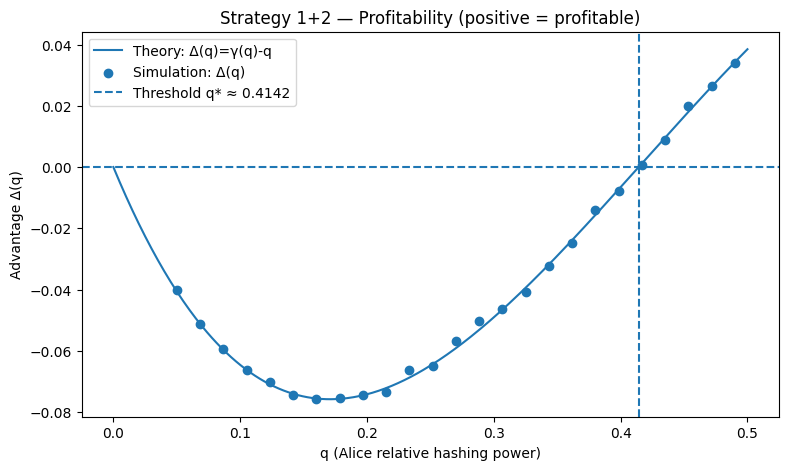

In [ ]:
delta_theory = gamma_plot - q_plot
delta_sim = df["gamma_sim"].to_numpy() - df["q"].to_numpy()

plt.figure(figsize=(9, 5))
plt.plot(q_plot, delta_theory, label="Theory: Δ(q)=γ(q)-q")
plt.scatter(df["q"], delta_sim, label="Simulation: Δ(q)")
plt.axhline(0, linestyle="--")
plt.axvline(q_star, linestyle="--", label=f"Threshold q* ≈ {q_star:.4f}")
plt.xlabel("q (Alice relative hashing power)")
plt.ylabel("Advantage Δ(q)")
plt.title("Strategy 1+2 — Profitability (positive = profitable)")
plt.legend()
plt.show()



# Conclusion
We simulated **strategy 1+2** by decomposing mining into independent **attack cycles** with outcome space $\Omega=\{B,AAA,AAB,ABA,ABB\}$.

Each block discovery is won by Alice with probability $q$ and by Bob with probability $p=1-q$.

The Monte Carlo estimates
$$
\widehat{\gamma}=\frac{\widehat{\mathbb{E}}[G]}{\widehat{\mathbb{E}}[H]}$$
match the theoretical prediction:
$$
\gamma(q)=\frac{q^2(4-q)}{1+q+q^3}.
$$

Comparing to honest mining $$\gamma_{\text{honest}}=q$$, the advantage $\Delta(q)=\gamma(q)-q$ changes sign at:
$$
q^*=\sqrt{2}-1\approx 0.4142.
$$

Therefore, **above ~41.4% relative hashing power**, a rational miner has an incentive to deviate from honest mining and apply strategy 1+2, because it yields a higher long-run revenue rate than honest mining.
